# 语言模型构建与文本生成

1. 本章内容概述
2. 传统与神经网络语言模型
3. 基于神经网络模型的语言生成器
4. 使用神经网络完成唐诗生成器


## 本章内容概述

语言模型的构建目的是为了对语言中的各要素的分布进行估计，具有较长的研究历史和广泛的应用。传统的离散计数类语言模型，比如bigram，n-gram模型等在很多应用领域的结果得到了广泛认可。其基本假设通常是单词的分布服从n阶马尔可夫链。通过对连续n个单词出现频率进行计数并平滑来估计单词出现的概率。但是由于是离散模型，因此有稀疏性和泛化能力低的缺点。随着深度学习被广泛接纳，近年来神经网络语言模型（NLM）收到了广泛关注。相比传统的语言模型，神经网络语言模型属于连续模型，主要着力解决离散模型的两个主要痛点：通过将离散的n-gram单词组投影到致密的空间这种词嵌入技术以及将采用循环连接网络来解决传统语言模型稀疏性和泛化能力低的问题。在实践中，神经网络语言模型得到了较好的结果。

本章内容组织如下：

1. 首先，我们介绍传统与神经网络语言模型。我们主要集中在传统模型的原理，以及潜在问题的分析；同时引入神经网络模型，从最简单的前馈神经网络模型到现在常见的循环神经网络语言模型，依次解释其原理和优缺点；
2. 其次，我们将基于神经网络模型构造我们的语言生成器。这个模型基于循环神经网络模型，我们将详细介绍原理和对应的代码；
3. 最后，我们使用这个语言生成器搭建属于自己的唐诗生成器，并实例展示其效果。以后自己也可以作古诗了。


## 传统与神经网络语言模型
我们主要介绍基于n-gram的传统统计语言模型，以及常见的前馈神经网络模型和循环神经网络模型。

### 传统语言模型

传统的离散模型主要是统计语言模型，比如bigram或者n-gram语言模型，是对n个连续的单词出现概率进行建模。这类模型基于马尔可夫假设，将n个单词出现的概率：$p(w_1,w_2,…,w_n)$ 的估计任务分解为依次估计每个单词出现的条件概率。出于计算和推导便利性的考虑，这个条件不是基于该单词出现之前所有出现的单词，而是前m个单词：

$$
   p(w_n | w_{n-1}, w_{n-2}, \cdots, w_1) \approx p(w_n | w_{n-1}, \cdots, w_{n-m})
$$

上述公式表明，传统的语言模型假设我们对于一个单词在某个位置出现概率的估计可以通过计算该单词与前面m个单词同时出现频率相对于前面的m个单词同时出现的频率的比获得。这是朴素贝叶斯的思路。
1. 如果m为0，我们的估计只基于该单词在全部文本中相对于其他所有单词的频率，这个模型就是unigram模型；
2. 如果m为1，那么这个模型就是常见的bigram模型，
3. 如果m为2，那么这个模型就是trigram模型，其计算公式如下：

$$
   p(w_n | w_{n-1}, w_{n-2}) = \frac{\textrm{count}(w_n, w_{n-1}, w_{n-2})}{\sum_j \textrm{count}(w_j, w_{n-1}, w_{n-2})}
$$
如果把文本视为一个状态机，每一个出现的单词即是状态，上述公式也可以视为是一个m阶的马尔可夫链模型。

传统n-gram模型简单实用，但是却有两大致命缺点：稀疏性和泛化能力差。

#### 稀疏性
因为n-gram模型只能对文本中出现的单词或者单词组进行建模，当新的文本中出现意义相近但是没有在训练文本中出现的单词或者单词组的时候，传统离散模型无法正确计算这些训练样本中未出现的单词的应有概率，他们都会被赋予0概率预测值。这是非常不符合语言规律的事情。

举个例来讲，在一组汽车新闻中，“SUV”和“吉普”是同义词，可以交替出现，但是假设整个训练集中没有出现过“吉普”这个单词，那么在传统模型中对于“吉普”这个词的出现概率会输出接近于0的结果。

但是上述相似例子在实际生活中却是非常比比皆是，由于计算资源与数据的限制，我们经常会发现模型在使用中遇见在整个训练集中从未出现的单词组的情况。为了解决这种矛盾，传统方法是引入一些平滑【 J .Goodman. A bit of progress in language modeling. Technical Report MSR-TR-2001–72, Microsoft Research, 2001. 】或者back-off的技巧【R. Kneser and H. Ney. Improved backing-off for n-gram language modeling. In International Conference on Acoustics, Speech and Signal Processing, pages 181–184, 1995.】整体上，效果并没有预想的好。


#### 泛化能力差
除了对未出现的单词本身进行预测非常困难之外，离散模型还依赖于固定单词组合，需要完全的模式匹配，否则也无法正确输出单词组出现的概率。继续前述例子，假设新闻中一段话是“作为翻山越岭常用的SUV”，这句话和“作为越野用途的吉普”本身意思相近，一个好的语言模型是应该能够识别出后面这句话与前面那句无论从语法还是语义上都是非常近似，应该有近似的概率分布，但是离散模型是无法达到这个要求的。这就使得此类模型的泛化能力不足。Bengio等人在发布其神经网络语言模型的时候就专门指出了传统离散模型的这个弱点。

此外，对于n-gram模型来说，第一个公式的马尔可夫假设太强。人在对文字进行处理的时候，是能够将很长一段上下文纳入考虑，但是n-gram的离散模型只考虑待预测单词前面的n-1个单词，这个马尔可夫假设与实际情况并不相符，使得第一个公式中两个概率近似的要求其实并不能满足。

离散模型在计算上还存在“维度诅咒”的困难。从上面的公式可以看出，当我们将更多单词组合挑出来之后才能更精准地预测特定单词组出现的概率，但是这种组合的量是非常大的。假设我们的词库有一万个独立单词，对于一个包含4个单词的词组模式，潜在的单词组合多达10的20次方。这使得突破一定的预测精度非常困难。

### 神经网络语言模型
传统语言模型的上述几个内在缺陷使得人们开始把目光转向神经网络模型，期望深度学习技术能够自动化地学习代表语法和语义的特征，解决稀疏性问题，并提高泛化能力。我们这里主要介绍两类神经网络模型：前馈神经网络模型（FFLM）和循环神经网络模型（RNNLM）。前者主要设计来解决稀疏性问题，而后者主要设计来解决泛化能力，尤其是对长上下文信息的处理。在实际工作中，基于循环神经网络及其变种的模型已经实现了非常好的效果。

我们前面提到，语言模型的一个主要任务就是要解决给定到当前的上下文的文字信息，如何估计现在每一个单词出现的概率。Bengio等人提出的第一个前馈神经网络模型利用一个三层，包含一个嵌入层、一个全连接层、一个输出层，的全连接神经网络模型来估计给定n-1个上文的情况下，第n个单词出现的概率。其架构如下图所示：

<img src="./pics/FFLM.png" width="500">

- 这个模型首先将词典中的单词映射到一个给定维度的致密空间，这个映射就是图中的参数矩阵C。该矩阵行数等于词典中的单词数量，列数等于给定的致密空间的维度。单词在致密空间的映射就是单词的词向量表达，这点我们在第一节课里已经学到了。在该模型中，上下文不再由原始的$w_{n-1}, \cdots, w_{n-m+1}$表示，而是由$(C(w_{n-1}),⋯,C(w_{n-m+1}))$表示。

- 其次模型使用一个激活函数将每个单词对应的上下文映射到词典全部单词对应的条件概率分布空间中。

- 最后，该模型在训练过程中同时学习词向量的映射关系参数和上下文到单词出现的条件概率参数。

通过使用词向量的映射，前馈神经网络模型能解决稀疏性的问题。一些在训练集中没有遇到过单词由于其与上下文同时出现的关系，在词向量的空间中会与相类似的单词处于相近的位置，从而降低出现接近于0的条件概率的问题。该模型在实际应用过程中表现出了一定的泛化能力，但是该模型没有明确地对超出观察窗口的上下文信息进行处理。

第二类的循环神经网络模型就是为了解决上述固定窗口问题而出现的。前馈神经网络模型假设每个输入都是独立的，但是这个假设并不合理。经常一起出现的单词以后也经常出现的概率会更高，并且当前应该出现的词通常是由前面一段文字决定的，利用这个相关性能提高模型的预测能力。循环神经网络的结构能利用文字的这种上下文序列关系，从而有利于对文字建模。这一点相比前馈神经网络模型更接近人脑对文字的处理模型。比如一个人说："我最近要去美国出差，想顺便买点东西，因此需要兑换___ "。 对于在“__”中需要填写的内容，通过前文的“兑换”和“买”知道需要是一种货币，通过“美国”知道这个货币需要是“美元”。通过RNNLM能回溯到前两个分句的内容，形成对“美元”，“买”，“兑换”等上下文的记忆。一个典型的RNNLM模型结构如下图所示。

<img src='./pics/RNNLM.png' width=500>

在这个结构中，状态节点$s_t$是在t时间的状态节点，其计算公式为$sₜ = g(Ux_t + Ws_{t-1})$，其中g是非线性激活函数，这个公式表明RNNLM通过状态节点来实现记忆功能。底部的节点随着“追忆”时间展开而。如果需要记住前面10个输入信息，底部网络会变为一个10层的网络

RNNLM理论上可以保留无限长度的记忆，但是由于梯度消失（Gradient Vanishing）问题，记忆能力不长。对于一些语言模型来说，问题不大，毕竟一般通过前十几个单词当前应该出现的单词可以猜个八九不离十。梯度消失问题是指


Andrej Karpathy的这篇[博客](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) ("The Unreasonable Effectiveness of Recurrent Neural Networks")对循环神经网络进行了较好的介绍和归纳。从实践者的角度，我们编写代码实现以下几种循环神经网络的时候也有一定的规律可循。

![RNNtypes](./pics/RNNtypes.jpeg)

在keras里，这几种类型的RNN模型可以被归纳为如下几种代码编写模式：
- 一对一模式：这种情况下其实并没有处理任何序列信息，可以视作多层感知器，用Dense层即可。

<code>
model.add(Dense(output_size, input_shape=input_shape))
</code>
<br></br>
- 一对多模式：一般的做法是用chaining把多个节点连接起来，但是在keras里是通过把“一”这个元素拓展为跟“多”一样维度的节点来实现的，相当于使用了一个技巧。

<code>
model.add(RepeatVector(number_of_times, input_shape=input_shape))
model.add(LSTM(output_size, return_sequences=True))
</code>

<br></br>
- 多对一模式：这是比较简单常见的模式，跟传统的时间序列里的概念非常类似。

<code>
model = Sequential()
model.add(LSTM(1, input_shape=(timesteps, data_dim)))
</code>
<br></br>

- 多对多，类型一：这是处理了一个序列之后生成该序列最后时间之后的多个时间步的一个序列，常见的应用包括在时间序列预测里预测未来N个时间点的数据，或者根据上下文生成下一句话等。

<code>
model = Sequential()
model.add(LSTM(K, input_shape=(timesteps, data_dim), return_sequences=True))
</code>

<br></br>

- 多对多，类型二：这类问题是在处理一个序列的同时，根据序列的输入时间轴依次产生待预测的，与该时间轴相对应的新序列。通常的应用是在自然语言分析中自动生成语言要素的tagging, slot filling （QnA），或者自然语言生成等等这类问题。在keras里，这类问题需要使用 TimeDistributed这个layer wrapper。上一代keras中这个wrapper被称为TimeDistributedDense。其作用是将该层产生的数据依照$t$个时间步的次序逐个，独立地，与新的$t$个全连接层相连来生成对应所需的元素，比如上面提到的语言要素的标注。

<code>
model = Sequential()
model.add(Embedding(num_word, 128))
model.add(LSTM(128, return_sequences=True))
model.add(TimeDistributed(Dense(num_tag)))
model.add(Activation('softmax'))
</code>

In [4]:
# encoding=utf-8

import jieba
sentence = "我来到北京清华大学学经济学"
seg_list = jieba.cut(sentence, cut_all=True)
print("全模式 ： " + "/ ".join(seg_list), '\n')  

seg_list = jieba.cut(sentence, cut_all=False)
print("精确模式（缺省设置）： " + "/ ".join(seg_list), '\n')  

seg_list = jieba.cut_for_search(sentence) 
print("搜索引擎模式 ：" + "/ ".join(seg_list))

全模式 ： 我/ 来到/ 北京/ 清华/ 清华大学/ 华大/ 大学/ 学学/ 经济/ 经济学/ 济学 

精确模式（缺省设置）： 我/ 来到/ 北京/ 清华大学/ 学/ 经济学 

搜索引擎模式 ：我/ 来到/ 北京/ 清华/ 华大/ 大学/ 清华大学/ 学/ 经济/ 济学/ 经济学


### 基于神经网络模型的语言生成器

我们从上面了解了RNN和LSTM两类循环神经网络模型对于序列文字数据的建模具备较强能力，一个很自然的想法就是我们能不能通过训练一个这样的模型来让计算机自动生成文字呢？答案是肯定的。比如说很多外国网友就根据美国总统川普（Trump）的推特文字来构造“川普味”的文字生成器。有些是基于字符级别的，有些是基于单词级别的，都是根据前面输入的一串字符或者单词来预测当前位置最可能出现的单词是什么，将概率最高的单词或者字符挑出来再放入输入的字符串，从而生成下一个位置最可能的字符或者单词，如此循环往复。

但是我们需要了解这个模型的内部工作机制。这里我们使用一组简单的有序数组来演示。我们给定一个单位位移的映射：['a','a']--> 'b'， ['b','b'] --> 'c'，....，['z','z']--> 'a'。因为这是26个字母的轮换，我们直接用其索引下标来代替这些字母。a->1, ..., z->26。

In [5]:
xseq =[]
yseq = []
for i in range(3):
    for j in range(26):
        xseq.append([j+1, j+1])
        yseq.append([j+2])

In [6]:
import numpy as np
import pandas as pd
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG, display

In [7]:
length = len(xseq)
print(length)
xseq[:5]

78


[[1, 1], [2, 2], [3, 3], [4, 4], [5, 5]]

In [8]:
X = np.array(xseq).reshape(length, 1, 2)
y = np.array(yseq).reshape(length, 1)
print(X.shape)

(78, 1, 2)


In [9]:
# -*- coding: UTF-8 -*-
%matplotlib inline
import pandas as pd
import numpy as np
import gc, jieba, os, sys, time

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution1D, Flatten, MaxPooling1D, Embedding
from keras.layers import LSTM,TimeDistributed, Input
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image as ImgDisp
import jieba
plt.rcParams['figure.figsize']=(20, 10)

In [18]:
# define LSTM configuration
n_neurons = length
n_batch = length
n_epoch = 1000
# create LSTM
def LSTM_1(lstm_dim, input_shape, printsummary=True):
    model = Sequential()
    model.add(LSTM(lstm_dim, batch_input_shape=input_shape, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    if printsummary:
        print(model.summary())
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))
    return model

def LSTM_2(lstm_dim, input_shape, printsummary=True):
    model = Sequential()
    model.add(LSTM(lstm_dim, input_shape=input_shape))
    model.add(Dense(input_shape[0]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    if printsummary:
        print(model.summary())
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))
    return model

def LSTM_3(lstm_dim, input_shape, printsummary=True):
    model = Sequential()
    model.add(LSTM(lstm_dim, input_shape=input_shape, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    if printsummary:
        print(model.summary())
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))
    return model

In [29]:
# train LSTM with different iteration numbers
lstm_dim=26
X = np.array(xseq).reshape(length, 1, 2)
y = np.array(yseq).reshape(length, 1)
batch_size=39
input_shape=(batch_size, 1, 2)
result=dict()
for i in range(10):
    model = LSTM_1(lstm_dim, input_shape, printsummary=False);
    n_epoch = i*100+1
    t0=time.time()
    model.fit(X, y, epochs=n_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    result[i] = model.predict(X, batch_size=batch_size, verbose=0)
    dt = np.round(time.time() - t0, 2);
    print('完成迭代步骤：%s，耗时：%s 秒' % ((i+1), dt))

完成迭代步骤：1，耗时：5.59 秒
完成迭代步骤：2，耗时：7.5 秒
完成迭代步骤：3，耗时：8.52 秒
完成迭代步骤：4，耗时：9.47 秒
完成迭代步骤：5，耗时：11.71 秒
完成迭代步骤：6，耗时：12.03 秒
完成迭代步骤：7，耗时：13.94 秒
完成迭代步骤：8，耗时：14.27 秒
完成迭代步骤：9，耗时：15.97 秒
完成迭代步骤：10，耗时：17.09 秒


In [23]:
lstm_dim=26
X = np.array(xseq).reshape(1, length, 2)
y = np.array(yseq).reshape(1, length, 1)
input_shape2=(length, 2)
result3=dict()

for i in range(10):
    model3 = LSTM_3(lstm_dim, input_shape2, printsummary=False);
    n_epoch = i*100+1
    t0=time.time()
    model3.fit(X, y, epochs=n_epoch, batch_size=length, verbose=0)
    result3[i] = model3.predict(X, batch_size=length, verbose=0)
    dt = np.round(time.time() - t0, 2);
    print('完成迭代步骤：%s，耗时：%s 秒' % ((i+1), dt))

完成迭代步骤：1，耗时：4.84 秒
完成迭代步骤：2，耗时：18.02 秒
完成迭代步骤：3，耗时：32.59 秒
完成迭代步骤：4，耗时：43.81 秒
完成迭代步骤：5，耗时：58.81 秒
完成迭代步骤：6，耗时：71.66 秒
完成迭代步骤：7，耗时：83.25 秒
完成迭代步骤：8，耗时：97.92 秒
完成迭代步骤：9，耗时：109.98 秒
完成迭代步骤：10，耗时：123.25 秒


生成不同迭代步数下的结果拟合曲线

D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

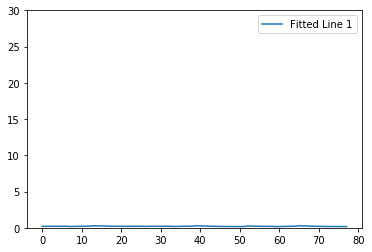

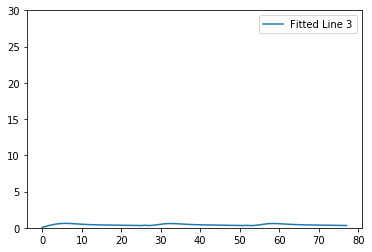

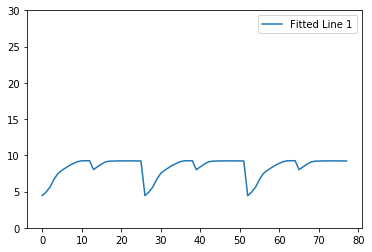

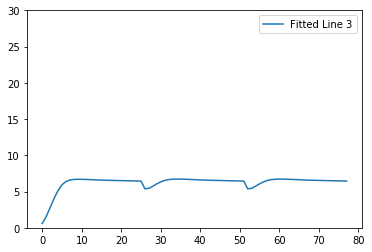

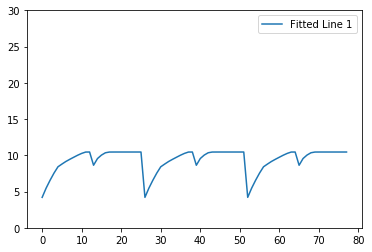

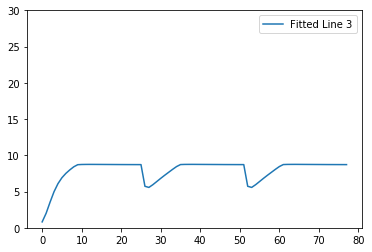

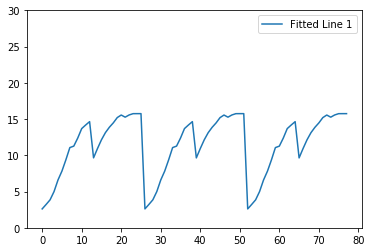

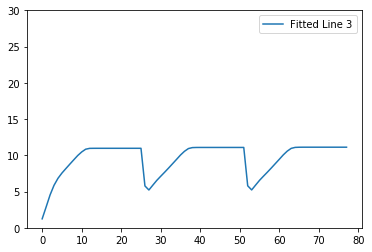

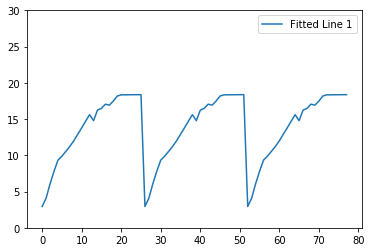

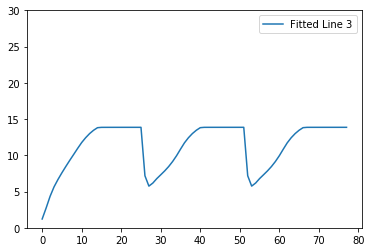

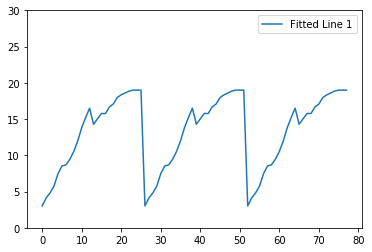

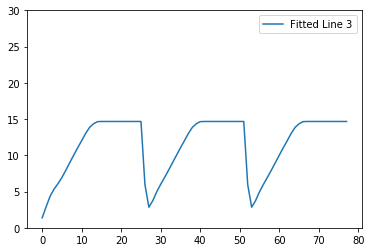

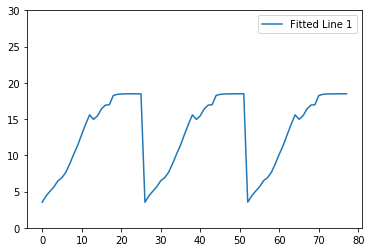

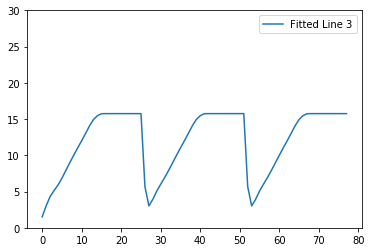

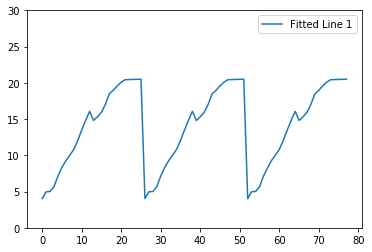

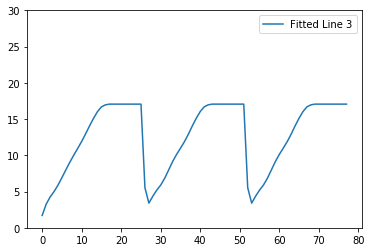

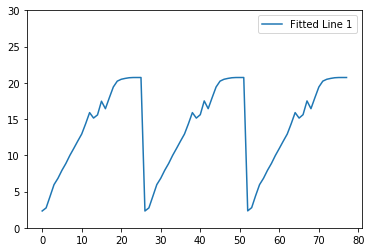

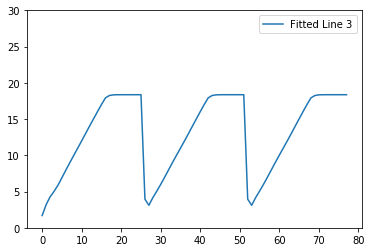

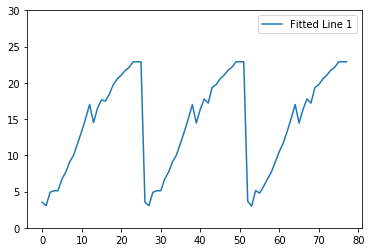

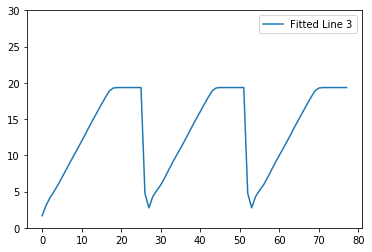

In [30]:
fig = plt.figure()
#fig, axes = plt.subplots(nrows=10, ncols=2)
for i in range(10):
    fname1 = './pics/one_to_one_'+str(i)+'.png' 
    pltres1 = pd.DataFrame(np.array(result[i]), columns=['Fitted Line 1']).plot()
    plt.ylim(0, 30)
    plt.savefig(fname1)
    
    fname3 = './pics/many_to_one_'+str(i)+'.png' 
    pltres3 = pd.DataFrame(np.array(result3[i][0]), columns=['Fitted Line 3']).plot()
    plt.ylim(0, 30)
    plt.savefig(fname3)    

In [28]:
from PIL import Image
im1=Image.open("./pics/one_to_one_0.png")
im3=Image.open("./pics/many_to_one_0.png")
images1=[]
images3=[]
for i in range(9):
    fname1 = './pics/one_to_one_'+str(i+1)+'.png'
    images1.append(Image.open(fname1))
    fname3 = './pics/many_to_one_'+str(i+1)+'.png'
    images3.append(Image.open(fname3))

im1.save('one_to_one_gif.gif', save_all=True, append_images=images1,loop=0,duration=15,comment=b"fitting path")

im3.save('many_to_one_gif.gif', save_all=True, append_images=images3,loop=0,duration=15,comment=b"fitting path")

从生成的图像可以看出，神经网络输出的初始值是接近为0的状态，第一次迭代后，模型能学到几个关键点：数据有周期性，并且周期是26，在每一个周期内大体上是递增关系。随后模型能学习到这个周期内的递增关系不仅仅在一开始几个值存在，而是逐渐从周期的开始值到周期的末尾都是存在的。因此也可以看到


![1to1](one_to_one_gif.gif "One to One")


![many_to_1](many_to_one_gif.gif "Many to One")

## AI唐诗生成器

诗歌是一种比较适合生成式建模的文字类型，可以在单个文字级别建

文字处理需要做几个事情：
1. 标题去掉，只保留诗歌主题。
2. 每一首诗作为一个独立的元素纳入文本列表，从而可以使用标注类合并处理。
3. 一些比较稀疏的词要过滤掉，比如频次低于 3次，或者只保留前N个字，等。

In [1]:
# 将每一首诗读为一个列表元素，全部诗歌为一个列表
# 可用于中文标注类的应用
fileopen = open("./nlp_data/poems_data/poetry.txt", encoding='utf-8')
alltext0 = []
with fileopen as fo:
    #去掉标题
    for line in fo:
        alltext0.append(line.strip().split(':')[-1])

print('出现的汉字集合大小为：%s' % (len(set(' '.join(alltext0)))) )
print('句子总数：%s' % len(alltext0))

出现的汉字集合大小为：7558
句子总数：43030


查看一下分离中文的效果

In [2]:
print(' '.join(alltext0[1]))

晚 霞 聊 自 怡 ， 初 晴 弥 可 喜 。 日 晃 百 花 色 ， 风 动 千 林 翠 。 池 鱼 跃 不 同 ， 园 鸟 声 还 异 。 寄 言 博 通 者 ， 知 予 物 外 志 。


引入中文标注类来分析中文文本，这里在单个字级别上分拆。

In [2]:
import cntext
tokenizer = cntext.cnTokenizer(char_level=True, filters=' ')
%time tokenizer.fit_on_cntexts(alltext0)
%time text_sequences=tokenizer.cntexts_to_sequences(alltext0)

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Wall time: 2.14 s
Wall time: 1.53 s


In [3]:
new_text_sequences = [w for w in text_sequences if len(w)>0]
print(new_text_sequences[:3])
print(len(text_sequences))
print(len(new_text_sequences))

[[57, 183, 345, 1205, 562, 1, 19, 392, 157, 60, 87, 2, 168, 6, 458, 366, 200, 1, 195, 115, 161, 16, 625, 2, 212, 129, 53, 141, 178, 1, 210, 1739, 240, 84, 485, 2, 1219, 371, 168, 313, 38, 1, 793, 89, 1430, 598, 13, 2], [195, 365, 962, 29, 2295, 1, 168, 382, 1390, 105, 482, 2, 9, 3602, 180, 16, 98, 1, 6, 257, 62, 129, 240, 2, 231, 300, 1626, 3, 114, 1, 331, 157, 60, 102, 475, 2, 342, 156, 1901, 303, 280, 1, 31, 1317, 263, 175, 799, 2], [8, 72, 19, 656, 1092, 1, 393, 40, 157, 16, 1050, 2, 202, 113, 83, 777, 154, 1, 258, 281, 110, 213, 88, 2, 4252, 598, 147, 867, 448, 1, 452, 422, 256, 1116, 14, 2, 1751, 46, 378, 235, 571, 1, 1436, 516, 81, 2349, 229, 2, 212, 990, 246, 849, 1204, 1, 533, 387, 340, 928, 71, 2, 12, 611, 2066, 113, 54, 1, 362, 140, 11, 5, 230, 2]]
43030
43019


In [10]:
word_counts_df = pd.DataFrame.from_dict(tokenizer.word_counts, orient='index')
word_counts_df.head()

""


In [9]:
print(np.max(np.max(text_sequences)))

7501


In [10]:
print('总字数:', len(tokenizer.word_counts))
word_counts_df = pd.DataFrame.from_dict(tokenizer.word_counts, 
                              orient='index', 
                              columns=['counts'])
word_index_df = pd.DataFrame.from_dict(tokenizer.word_index, 
                              orient='index', 
                              columns=['index'])
temp=pd.merge(word_counts_df, word_index_df, 
              left_index=True, right_index=True)
temp.sort_values(by='counts', ascending=True).head(10)

总字数: 7557


,counts,index
韔,1,7557
躘,1,6913
琲,1,6914
瓃,1,6915
掫,1,6916
餫,1,6917
窬,1,6918
硝,1,6919
飂,1,6920
踍,1,6921


我们看到有大量的低频生僻词，这些其实可以从待建模的空间里去掉。我们可以考虑只保留出现过至少3次以上的单字。从下面的频次图可以看到有大约5995个单词都出现过3次及以上。因此我们可以在我们的标注类里面指定num_words_to_keep为5995，即保留最高频次的前5995个单字。当设立了最高频保留词字数后，tokenizer仍然会将所有单字梳理出来，但是在将文字转化为下标序列的时候，只会保留最多5995个单字。

最小的频次为2的单字排序号
5995


(0, 5)

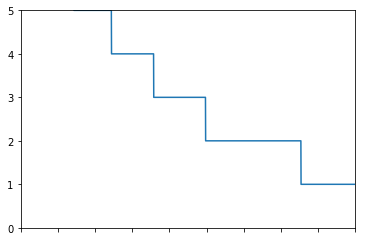

In [11]:
temp.sort_values(by='counts', ascending=False, inplace=True)
print('最小的频次为2的单字排序号')
print(np.min(temp.reset_index().index.values[temp.counts==2]))
temp.sort_values(by='counts', ascending=False).counts.plot()
plt.xlim(5000, 6800)
plt.ylim(0, 5)

In [12]:
num_words_to_keep = 5995
tokenizer2 = cntext.cnTokenizer(num_words=num_words_to_keep, char_level=True, filters=' ')
%time tokenizer2.fit_on_cntexts(alltext0)
%time text_sequences=tokenizer2.cntexts_to_sequences(alltext0)

Wall time: 29.2 s
Wall time: 2.14 s


In [13]:
print('总字数:', len(tokenizer2.word_counts))
vocab_size = np.max([np.max(sentence) for sentence in text_sequences if len(sentence)>0])
print('建模用总下标数：', vocab_size)
word_counts_df = pd.DataFrame.from_dict(tokenizer2.word_counts, 
                              orient='index', 
                              columns=['counts'])
word_index_df = pd.DataFrame.from_dict(tokenizer2.word_index, 
                              orient='index', 
                              columns=['index'])
temp=pd.merge(word_counts_df, word_index_df, 
              left_index=True, right_index=True)
print('最常见字符')
print(temp.sort_values(by='counts', ascending=False).head(), '\n')
print('最不常见字符')
print(temp.sort_values(by='counts').head())

总字数: 7557
建模用总下标数： 5994
最常见字符
   counts  index
，  231937      1
。  228996      2
不   26183      3
人   20821      4
山   15996      5 

最不常见字符
   counts  index
韔       1   7557
躘       1   6913
琲       1   6914
瓃       1   6915
掫       1   6916


In [16]:
print(word_index_df.shape)
print(word_counts_df.shape)

(7557, 1)
(7557, 1)


In [17]:
tokenizer2.word_index[';']

6745

In [18]:
import pandas as pd
import numpy as np
import gc, jieba, os, sys, time

import keras
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Convolution1D, Flatten, MaxPooling1D, Embedding
from keras.layers import LSTM,TimeDistributed, Input
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file

In [19]:
def data_generator(text_sequences, max_len, voc_size): 
    '''
    生成数据， text_sequences已经是索引下标
    ''' 
    i = 0 
    while 1:
        sentence = text_sequences[i]
        #如果是一个空的句子（文中文字均为生僻字），进入下一个迭代
        if len(sentence)<=0:
            continue
        j = 0
        while 1:
            # 当前列表元素跑完，进入下一首诗
            if j + max_len >= len(sentence): 
                i += 1 
                break 
            x = sentence[j: j + max_len] 
            y = sentence[j + max_len]     
            
            y_out = np.zeros( (1, voc_size), dtype=np.int ) 
            y_out[0, y] = 1

            x_out = np.zeros( (1, max_len, voc_size), dtype=np.int ) 
            for t, char_index in enumerate(x): 
                x_out[0, t, char_index] = 1

            yield x_out, y_out 
            j += 1

def build_model(vocab_size, max_len, learning_rate = 0.001): 
    '''建立一个双层LSTM模型''' 
    lstm_dim1 = 256
    lstm_dim2 = 256
    input_tensor = Input(shape=(max_len, vocab_size)) 
    lstm = LSTM(lstm_dim1, activation='tanh', return_sequences=True)(input_tensor) 
    dropout = Dropout(0.5)(lstm) 
    
    lstm = LSTM(lstm_dim2, activation='tanh', return_sequences=False)(dropout) 
    dropout = Dropout(0.5)(lstm)    
    
    dense = Dense(vocab_size, activation='softmax')(dropout) 
    model = Model(inputs=input_tensor, outputs=dense) 
    optimizer = Adam(lr=learning_rate) 
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model
    

def generate_text(model, length, vocab_size):
    ix = [np.random.randint(vocab_size)]
    y_char = [ix_to_char[ix[-1]]]
    X = np.zeros((1, length, vocab_size))
    for i in range(length):
        X[0, i, :][ix[-1]] = 1
        print(ix_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(ix_to_char[ix[-1]])
    return ('').join(y_char)


def sample(preds, diversity=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / diversity
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    
    if (epoch) % 1 ==0 :
        print()
        print('----- 文字生成，当前迭代 ：%d' % epoch)

        start_index = np.random.randint(0, len(text_sequences))
        #start_index = 0
        for diversity in [1.1]:
            #print('----- diversity:', diversity)

            generated = ''
            numerical_sentence = text_sequences[start_index][0:max_len]
            sentence=''
            for i in range(len(numerical_sentence)):
                sentence += tokenizer2.index_word[numerical_sentence[i]]
            generated += sentence
            print('---Diversity :' + str(diversity)+ ';---Seed: "' + sentence + '"')
            #sys.stdout.write(generated)

            for i in range(20):
                x_pred = np.zeros((1, max_len, vocab_size))
                for t, char in enumerate(sentence):
                    x_pred[0, t, tokenizer2.word_index[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = tokenizer2.index_word[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()
    else:
        print()
        #print('----- 此次迭代不输出: %d' % epoch)

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

下面看看一次迭代需要多少步骤，即看看每一次迭代，数据生成器需要进行多少次yield操作才能遍历完文本序列集合。

In [22]:
%%time
total_yield = 0 
voc_size = vocab_size
max_len = 7
for i in range(len(text_sequences)):
        sentence = text_sequences[i]
        j = 0
        if len(sentence)<=0:
            continue
            
        for j in range(len(sentence)-max_len-1):
            # 当前列表元素跑完，进入下一首诗
            if j + max_len >= len(sentence): 
                i += 1 
                break                 

            total_yield += 1

            
print(total_yield)

2704554
Wall time: 859 ms


In [23]:
'''训练vanilla模型''' 
batch_size=1024
vocab_size = vocab_size
steps = total_yield // batch_size
max_len = 7
weight_file = 'poetry_model_weight.h5'
number_of_epoch = 10
print('----迭代内步数 ：%s' % steps)
model = build_model(vocab_size, max_len) 
callbacks = [
             ModelCheckpoint(weight_file, save_weights_only=True), 
             print_callback
            ]
data_generator_output = data_generator(text_sequences, max_len, vocab_size)
model.fit_generator( generator = data_generator_output, 
                    verbose = 1, 
                    steps_per_epoch = steps, 
                    epochs = number_of_epoch, 
                    callbacks = callbacks)

----迭代内步数 ：2641
Epoch 1/10
2641/2641 [==============================] - 105s 40ms/step - loss: 7.1668 - acc: 0.0890

----- 文字生成，当前迭代 ：0
---Diversity :1.1;---Seed: "送文迎武递参差"
广瓮艇岩云壈烟改苑彗动菲岩氛日坡将涬茕薨
Epoch 2/10
2641/2641 [==============================] - 102s 39ms/step - loss: 6.3718 - acc: 0.1325

----- 文字生成，当前迭代 ：1
---Diversity :1.1;---Seed: "琪树芊芊玉蕊新"
萦窑臭波打动月散露晚遵抚，绁摇青中山，栊
Epoch 3/10
2641/2641 [==============================] - 101s 38ms/step - loss: 6.9675 - acc: 0.1140

----- 文字生成，当前迭代 ：2
---Diversity :1.1;---Seed: "百雉层城上将坛"
独编燠柴踪巡遥人风泉必还汉清岭皇侄衢沙器
Epoch 4/10
2641/2641 [==============================] - 101s 38ms/step - loss: 6.5888 - acc: 0.1655

----- 文字生成，当前迭代 ：3
---Diversity :1.1;---Seed: "隔岸红尘忙似火"
轩辇隐不机阳雾抚淳终美凌背终朱深点灞此盖
Epoch 5/10
2641/2641 [==============================] - 101s 38ms/step - loss: 6.9634 - acc: 0.1238

----- 文字生成，当前迭代 ：4
---Diversity :1.1;---Seed: "水面细风生，菱"
猿拥露谈。蛮重罢起繁虹恶遐结，昭波襟惟阶
Epoch 6/10
2641/2641 [==============================] - 102s 38ms/step - loss: 7.2247 - acc: 0

我们看到，一开始AI生成的文字杂乱无序，没有任何意义。即使到第3次迭代也是一些杂乱无序的单字。到第5次迭代的时候，AI已经学会每五个字要有一个标点符号，虽然逗号和句号还弄不清楚。但是这个是最容易注意的文字模式，因此在较早的迭代模式下就学到了。当然在后面的迭代里还有一些反复，并且里面的文字仍然是无厘头。不过，我们注意到每一句已经有那么点意思了，比如在第8次迭代里的“八”与“六”配对，“君”与“昭”配对，在第9次迭代里的“火”与“水”配对等，都无不体现了一些诗的意境。

读者可以自己调整模型结构和超参数来实验不同的模型，比较一下结果。